In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import pandas as pd
import numpy as np
import glob

import os

rcParams['svg.fonttype'] = 'none'

In [2]:
time_info_j1 = !ls qc/bladderTMAs_j1/*/qc/time_info.csv
print(len(time_info_j1))

74


In [3]:
time_info_j2 = !ls qc/bladderTMAs_j2/*/qc/time_info.csv
print(len(time_info_j2))

105


In [4]:
time_info_j4 = !ls qc/bladderTMAs_j4/*/qc/time_info.csv
print(len(time_info_j4))

105


In [5]:
dfs = []
for fname in time_info_j1:
    sample_id = fname.split('/')[2]
    df = pd.read_csv(fname, index_col=0, header=0)
    df['sample_id'] = sample_id
    df['j'] = [1]*df.shape[0]
    dfs.append(df.copy())
    
for fname in time_info_j2:
    sample_id = fname.split('/')[2]
    df = pd.read_csv(fname, index_col=0, header=0)
    df['sample_id'] = sample_id
    df['j'] = [2]*df.shape[0]
    dfs.append(df.copy())   
    
# for fname in time_info_j3:
#     sample_id = fname.split('/')[2]
#     df = pd.read_csv(fname, index_col=0, header=0)
#     df['sample_id'] = sample_id
#     df['j'] = [3]*df.shape[0]
#     dfs.append(df.copy())
    
for fname in time_info_j4:
    sample_id = fname.split('/')[1]
    df = pd.read_csv(fname, index_col=0, header=0)
    df['sample_id'] = sample_id
    df['j'] = [4]*df.shape[0]
    dfs.append(df.copy())
    
time_info = pd.concat(dfs, axis=0)
time_info

,cycle,channel,time,function,sample_id,j
0,0,0,74.828491,EDOF,210226_Bladder_TMA1_reg10,1
1,0,0,11.913049,Shading correction,210226_Bladder_TMA1_reg10,1
2,0,0,10.929900,Stitching,210226_Bladder_TMA1_reg10,1
3,13,0,75.514806,EDOF,210226_Bladder_TMA1_reg10,1
4,13,0,10.793132,Shading correction,210226_Bladder_TMA1_reg10,1
...,...,...,...,...,...,...
254,12,3,20.491862,EDOF,bladderTMAs_j4,4
255,12,3,3.403429,Shading correction,bladderTMAs_j4,4
256,12,3,5.131095,Cycle alignment,bladderTMAs_j4,4
257,12,3,1.349892,Background subtraction,bladderTMAs_j4,4


In [6]:
np.unique(time_info.function)

array(['Background subtraction', 'Cycle alignment', 'EDOF',
       'Shading correction', 'Stitching'], dtype=object)

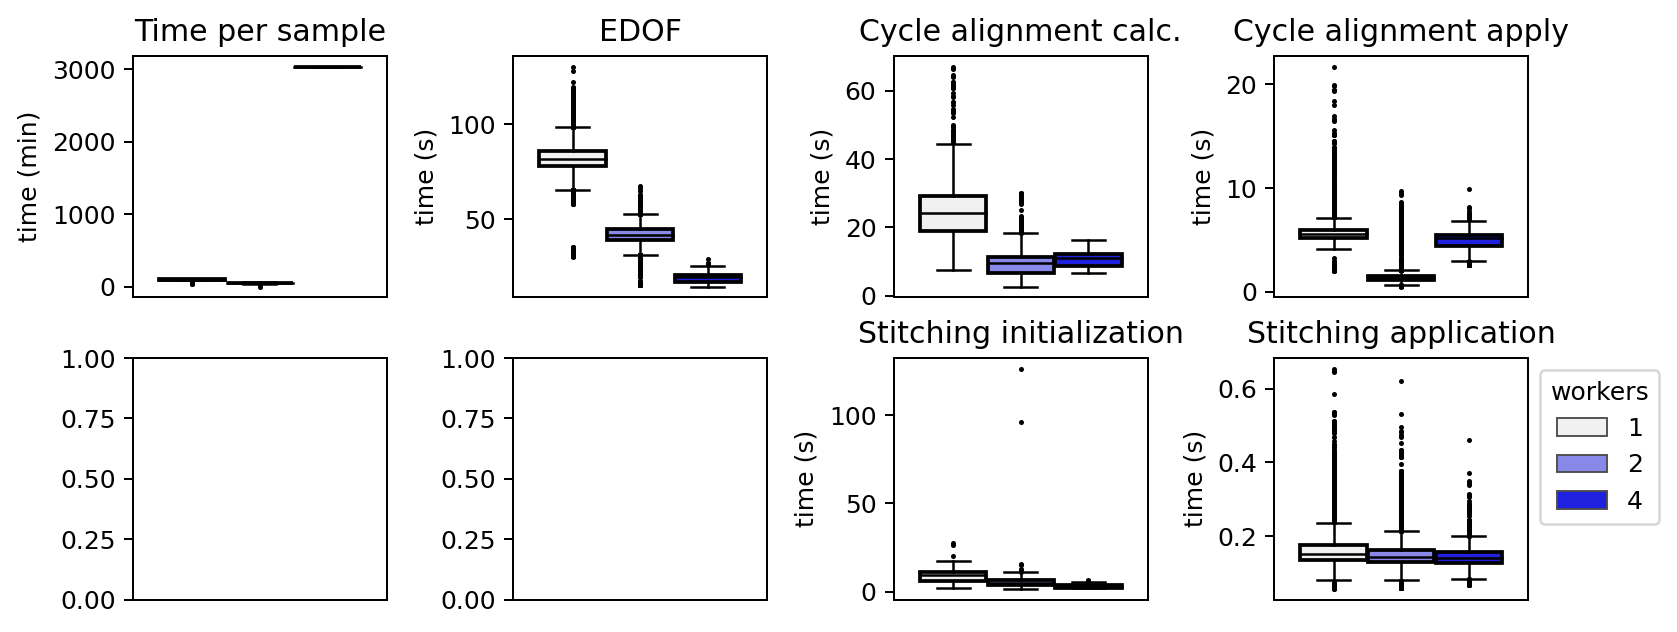

In [7]:
fig, axs = plt.subplots(2,4, figsize=(10,4), dpi=180, 
                        gridspec_kw=dict(hspace=0.25, wspace=0.5))
axs = axs.ravel()

for i,f in zip([1], ['EDOF']):
    ax = axs[i]
    p = sns.boxplot(x='function', y='time', hue='j', 
                data=time_info.loc[time_info.function==f],
                color='b', 
                fliersize=1,
                flierprops=dict(marker='o', markerfacecolor='k', markeredgecolor='k'),
                ax=ax
               )
    p.legend_.remove()
    ax.set_ylabel('time (s)')
    ax.set_title(f)
    

ax = axs[2]
p = sns.boxplot(x='function', y='time', hue='j', 
            data=time_info.loc[(time_info.function=='Cycle alignment')&(time_info.channel==0)&(time_info.cycle!=0)],
            color='b', 
            fliersize=1,
            flierprops=dict(marker='o', markerfacecolor='k', markeredgecolor='k'),
            ax=ax
           )
p.legend_.remove()
ax.set_ylabel('time (s)')
ax.set_title('Cycle alignment calc.')

ax = axs[3]
p = sns.boxplot(x='function', y='time', hue='j', 
            data=time_info.loc[(time_info.function=='Cycle alignment')&(time_info.channel!=0)&(time_info.cycle!=0)],
            color='b', 
            fliersize=1,
            flierprops=dict(marker='o', markerfacecolor='k', markeredgecolor='k'),
            ax=ax
           )
p.legend_.remove()
ax.set_ylabel('time (s)')
ax.set_title('Cycle alignment apply')


ax = axs[6]
p = sns.boxplot(x='function', y='time', hue='j', 
            data=time_info.loc[(time_info.function=='Stitching')&(time_info.channel==0)&(time_info.cycle==0)],
            color='b',
            fliersize=1,
            flierprops=dict(marker='o', markerfacecolor='k', markeredgecolor='k'),
            ax=ax
           )
p.legend_.remove()
ax.set_ylabel('time (s)')
ax.set_title('Stitching initialization')

        
# plt.savefig(f'timing_stitching_initialization.svg',
#             bbox_inches='tight', transparent=True)

ax = axs[7]
p = sns.boxplot(x='function', y='time', hue='j', 
            data=time_info.loc[(time_info.function=='Stitching')&(time_info.channel!=0)&(time_info.cycle!=0)],
            color='b', 
            fliersize=1,
            flierprops=dict(marker='o', markerfacecolor='k', markeredgecolor='k'),
            ax=ax
           )
p.legend_.remove()
plt.legend(title='workers', bbox_to_anchor=(1,1))
ax.set_ylabel('time (s)')
ax.set_title('Stitching application')


sample_workers = [f'{s}-{w}' for s,w in zip(time_info.sample_id, time_info.j)]
time_info['sample_workers'] = sample_workers
total_time = time_info.loc[:, ['time', 'sample_workers']].groupby('sample_workers').sum()
total_time['j'] = [int(x.split('-')[1]) for x in total_time.index]
total_time['function'] = ['total']*total_time.shape[0]
total_time['time'] = total_time['time'] / 60

ax = axs[0]
p = sns.boxplot(x='function', y='time', hue='j', 
            data=total_time,
            color='b', 
            fliersize=1,
            flierprops=dict(marker='o', markerfacecolor='k', markeredgecolor='k'),
            ax=ax
           )
p.legend_.remove()
ax.set_ylabel('time (min)')
ax.set_title('Time per sample')



for ax in axs:
    ax.set_xlabel(None)
    ax.set_xticks([])
    for i,box in enumerate(ax.artists):
        box.set_edgecolor('black')

        for j in range(i*6,i*6+6):
            line = ax.lines[j]
            line.set_color('k')
            line.set_linewidth(1)
            
# plt.savefig('timing_figure_panel.svg', bbox_inches='tight', transparent=True)